In [18]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import HumanMessage, SystemMessage
import os
import ast

os.environ["LANGCHAIN_TRACING_V2"] = "true"
file_path = input("Enter the path to the PDF file: ")
# create a vector store
loader = PyPDFLoader(file_path, extract_images=True)
pages = loader.load_and_split()
faiss_index = FAISS.from_documents(pages, OpenAIEmbeddings())
retriever = faiss_index.as_retriever(search_type="similarity", search_kwargs={"k": 10})
llm = ChatOpenAI(model="gpt-4o-mini")

# create a prompt for the contextualize_q_prompt that incorporates a chat history
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder(
            "chat_history"
        ),  # this placeholder will store a list of previous messages
        ("human", "{input}"),
    ]
)

# create a retriver that is history aware
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# qa system prompt
qa_system_prompt = """You are an assistant for question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know. \
Use three sentences maximum and keep the answer concise.\
If you have to answer a question that involves latex code, visualize it in a plain text format.\

{context}"""

# qa final prompt
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# final chain
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)



# second llm that creates a knowledge graph from a given text
llm_graph = ChatOpenAI(model="gpt-4o-mini")
graph_system_prompt = """

    You are an assistant for creating a knowledge graph triplets from a given text.\
    A triplet is a triple of the form (subject, predicate, object).\
    The subject, predicate, and object must all be nodes in the knowledge graph so they must not be too long.\
    The predicate must be a relation between the subject and object.\
    Transform in triplets only the part of the text that you think is worth doing so.\
    Answer only with the one and only one list of triplets.\
    Format your response as a Python list of tuples, like this:\
    [("Subject1", "Predicate1", "Object1"), ("Subject2", "Predicate2", "Object2")]\
    Do not include any other text or explanations in your response.\
    {text}

"""


# chatbot with history


chat_history = []
graph_history = []
print(
    "Chatbot: Hello! I'm ready to answer your questions about the pdf document. Type 'exit' to end the conversation."
)

while True:

    user_input = input("You: ")
    print("You: ", user_input)
    if user_input.lower() == "exit":
        print("Chatbot: Goodbye!")
        break
    ai_msg = rag_chain.invoke({"input": user_input, "chat_history": chat_history})
    chat_history.extend([HumanMessage(content=user_input), ai_msg["answer"]])
    graph_message = [
        SystemMessage(content=graph_system_prompt),
        HumanMessage(content=ai_msg["answer"]),
    ]
    graph_ai_msg = llm_graph.invoke(graph_message)
    graph_history.extend(ast.literal_eval(graph_ai_msg.content))
    print("Chatbot: ", end="", flush=True)
    print(ai_msg["answer"])
    print("graph:", graph_ai_msg.content)


Chatbot: Hello! I'm ready to answer your questions about the pdf document. Type 'exit' to end the conversation.
You:  what is a decoder?
Chatbot: A decoder is a component in sequence transduction models, such as those used in machine translation, that generates an output sequence of symbols from a sequence of continuous representations provided by the encoder. It produces the output one element at a time in an auto-regressive manner, using previously generated symbols as additional input for generating the next symbol. This structure is essential for converting the encoded information into a coherent and contextually accurate output.
graph: [("Decoder", "is a", "component in sequence transduction models"), ("Decoder", "generates", "output sequence of symbols"), ("Output sequence of symbols", "is from", "continuous representations"), ("Continuous representations", "are provided by", "Encoder"), ("Decoder", "produces", "output one element at a time"), ("Output", "uses", "previously gener

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
def plot_graph(graph_history):
    G = nx.DiGraph()
    for triplets in graph_history:
        for triplet in triplets:
            G.add_edge(triplet[0].lower(), triplet[2].lower(), label=triplet[1].lower())

    pos = nx.spring_layout(G, seed=42, k=0.5)  # Increased k for more spread
    labels = nx.get_edge_attributes(G, 'label')
    plt.figure(figsize=(50, 30))

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.8)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='red', alpha=1)

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=20, label_pos=0.5, verticalalignment='baseline')

    # Draw node labels outside the nodes
    for node, (x, y) in pos.items():
        plt.text(x, y+0.05, node, fontsize=30, ha='center', va='center')

    plt.title('Knowledge Graph')
    plt.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

In [19]:
graph_history

[('Decoder', 'is a', 'component in sequence transduction models'),
 ('Decoder', 'generates', 'output sequence of symbols'),
 ('Output sequence of symbols', 'is from', 'continuous representations'),
 ('Continuous representations', 'are provided by', 'Encoder'),
 ('Decoder', 'produces', 'output one element at a time'),
 ('Output', 'uses', 'previously generated symbols'),
 ('Structure', 'is essential for', 'converting encoded information'),
 ('Decoder', 'is part of', 'Sequence Transduction Models'),
 ('Decoder', 'takes', 'Continuous Representations'),
 ('Decoder', 'generates', 'Output Sequence'),
 ('Decoder', 'operates in', 'Auto-regressive Manner'),
 ('Decoder', 'produces', 'One Symbol'),
 ('Decoder', 'uses', 'Previously Generated Symbols'),
 ('Decoder', 'is crucial for', 'Transforming Encoded Information')]

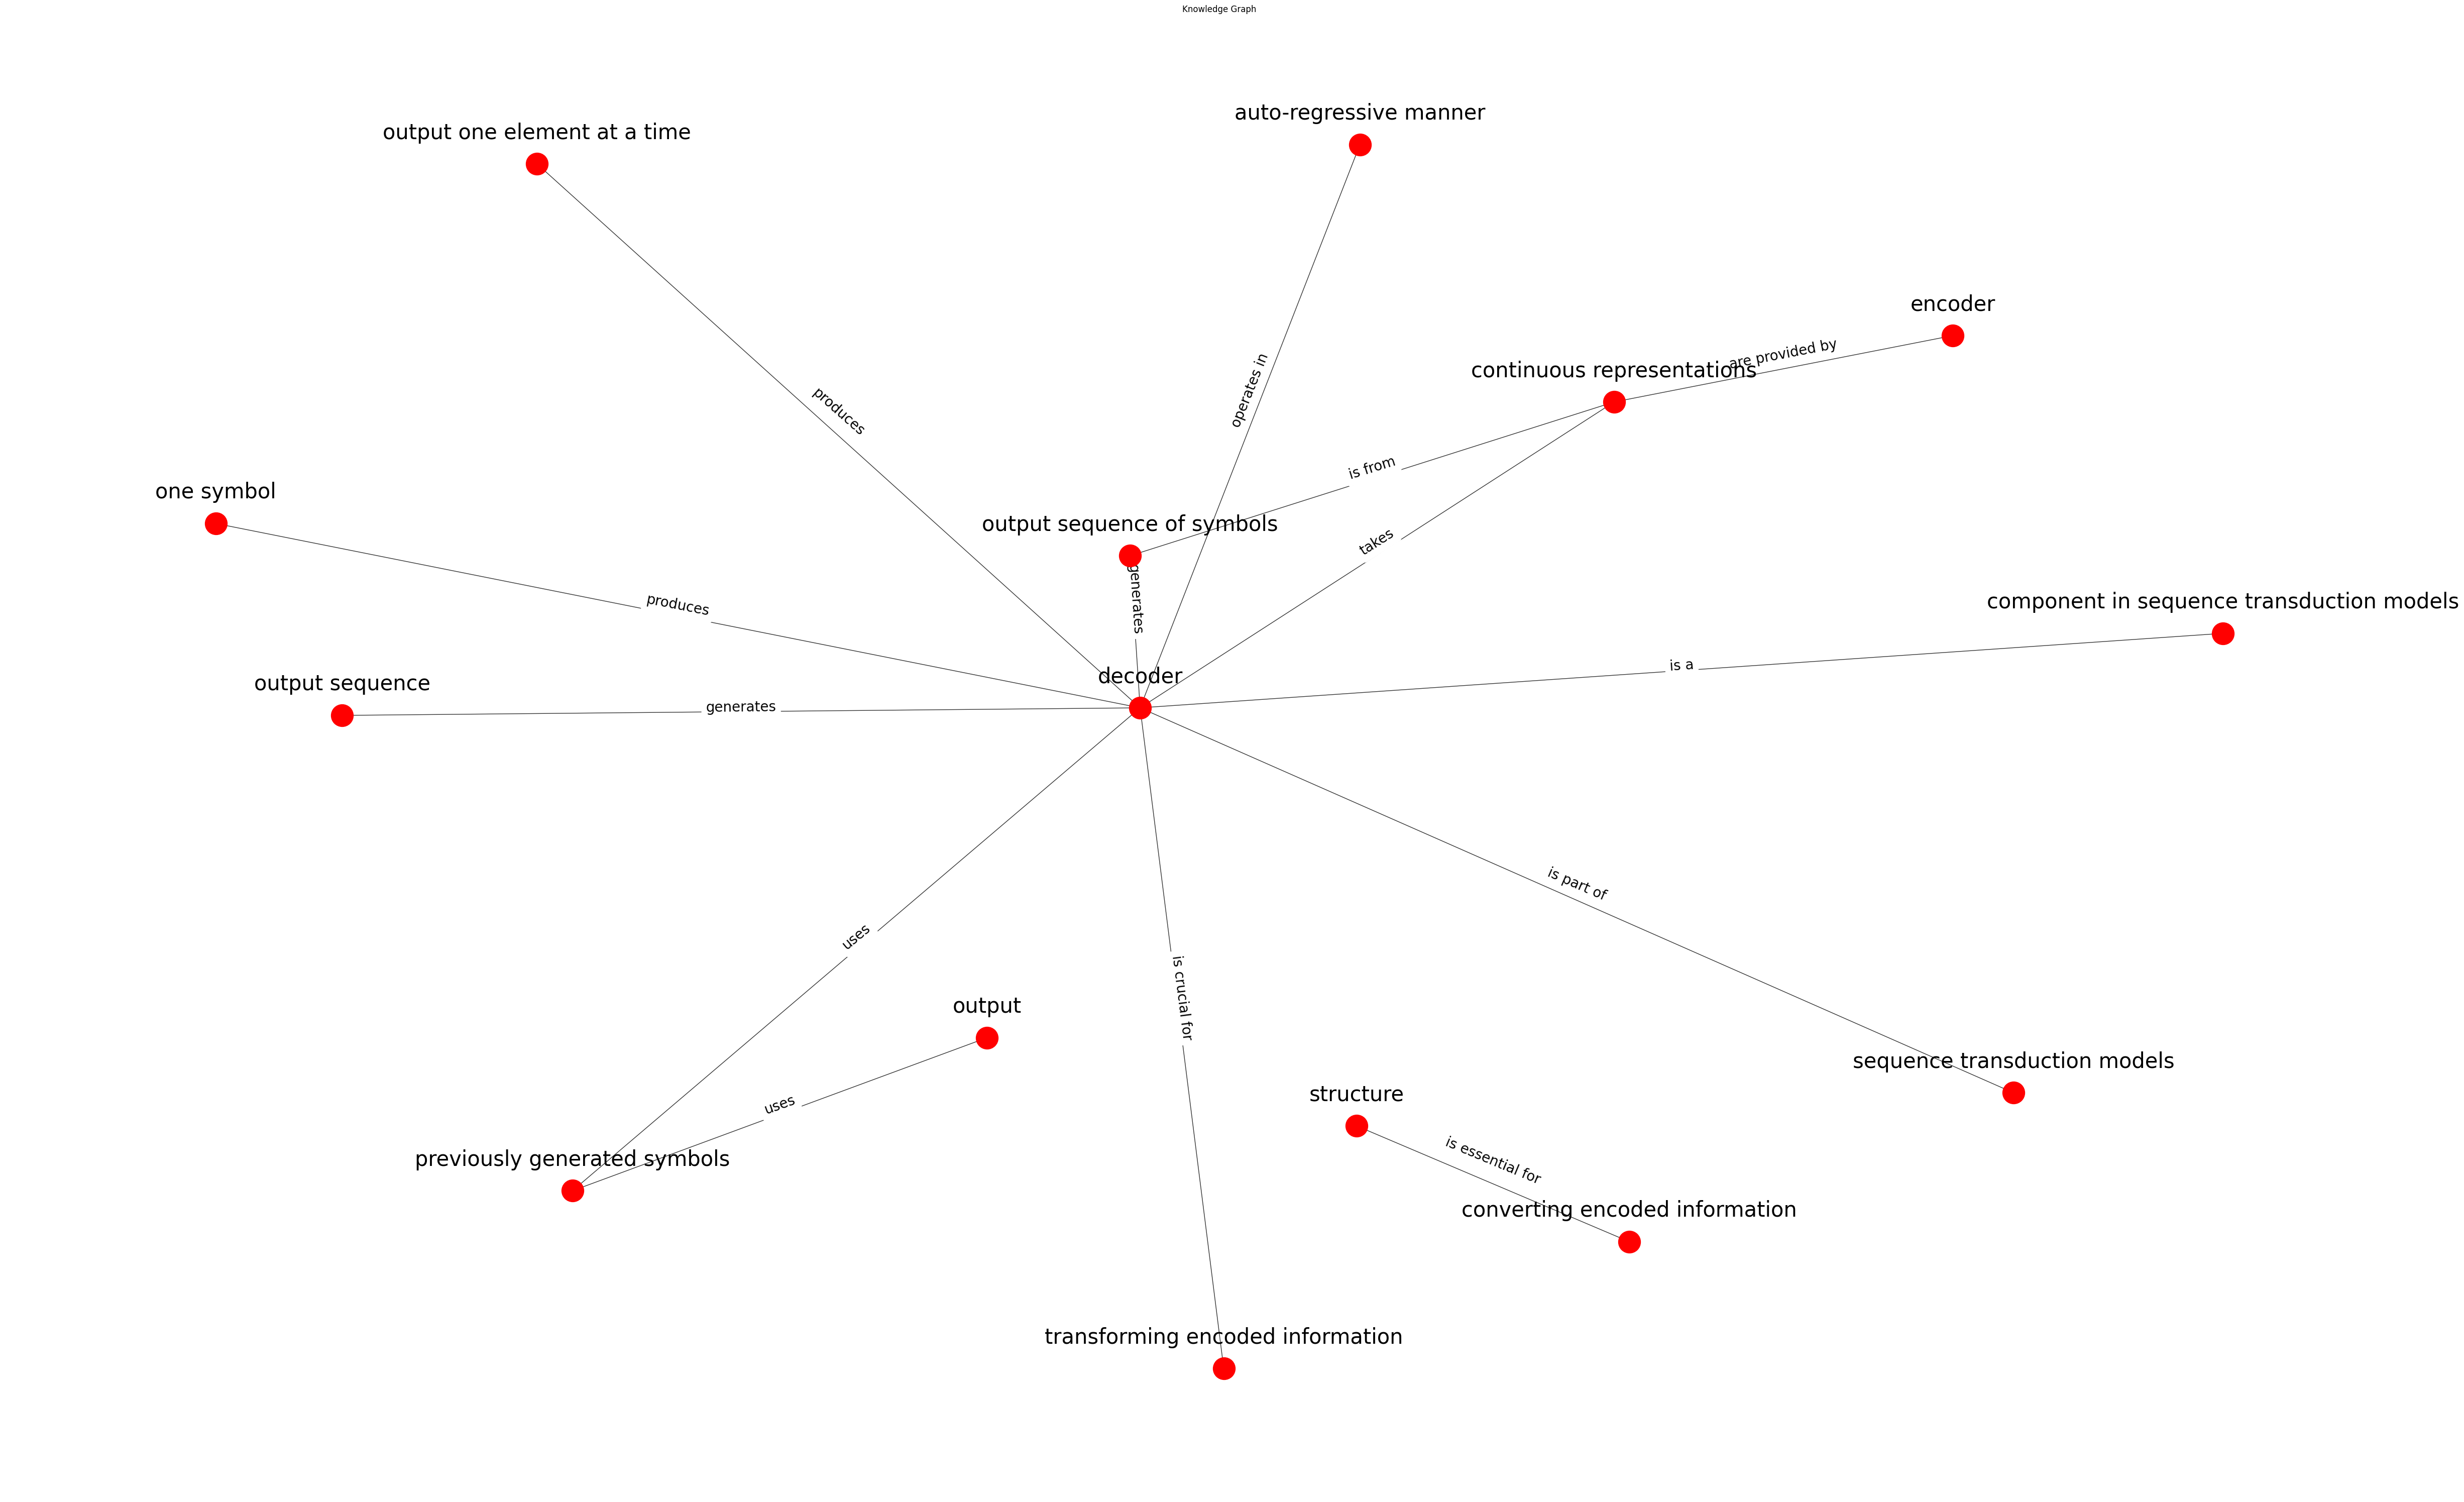

In [20]:
plot_graph([graph_history])